In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#from matplotlib.ticker import MultipleLocator
import matplotlib as mpl
import numpy as np
import random
from scipy import stats
import glob
from dask.distributed import Client, LocalCluster
from itertools import product
from cftime import DatetimeNoLeap
from resampling import _resample_iterations_idx
from statsmodels.stats.multitest import fdrcorrection


In [2]:
root_path = '/mnt/data04/model/CMAM/0A.daily/'
label_ls = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I','J','K','L']
its = 10000
sel_var = 'nkeff'
comp_name = 'himalayas'#'eastasia'

In [3]:
plt.rcParams.update({'font.size': 22})
sns.set_style('whitegrid')

In [4]:
def open_date_file(file_path):
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    df['BeginDate'] = df.BeginDate.apply(lambda t: pd.to_datetime(t, format='%Y-%m-%d'))
    return df

random.seed(0)

def g_kde(y, x):
    # it may happen that y is full of zeros => singular matrix
    try:
        kde = stats.gaussian_kde(y)
        res = kde(x)
    except:
        res = np.array(np.nan)
    return res

In [7]:
client = Client(LocalCluster(host='195.113.23.121')) # 
client

Client Scheduler: tcp://195.113.23.121:46299 Dashboard: http://195.113.23.121:8787/status,Cluster Workers: 8 Cores: 64 Memory: 503.57 GiB


# Data loading

In [5]:
infolder = ''
sel_var = 'nkeff-xcontour'
ds_clim = xr.open_dataset(
    f'{root_path}{infolder}{sel_var}/{sel_var}_climatology_woSSW.nc'
)
ds_clim

<xarray.Dataset>
Dimensions:           (isentropic_level: 45, month: 12, new: 181)
Coordinates:
  * new               (new) float32 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * isentropic_level  (isentropic_level) int64 400 410 420 430 ... 820 830 840
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    nkeff             (month, isentropic_level, new) float64 ...

## Composite

In [6]:
infolder = 'composites_woSSW_DJFonly/'
what_ls = ['anomalies','absolute']
sel_var = 'nkeff'
ds_ls = [
    xr.open_dataarray(
        f'{root_path}{infolder}{sel_var}_{what}_comp_{comp_name}_20days.nc'
    ) for what in what_ls
]
ds_all = xr.concat(ds_ls, dim = 'what')    
ds_all['what'] = what_ls
ds_all = ds_all.isel(new=0).reset_coords(drop=True)#.reset_coords('new', drop=True)#.reset_coords(drop=True)#.rename({'new':'lat'})
ds_all

<xarray.DataArray 'nkeff' (what: 2, lag: 21, isentropic_level: 45, lat: 181)>
array([[[[            nan,             nan,             inf, ...,
           1.52080036e+00,  1.52080036e+00,  1.52080036e+00],
         [            nan,             nan,             inf, ...,
           1.65955464e+00,  1.65955464e+00,  1.65955464e+00],
         [            nan,             nan,             inf, ...,
           1.88942366e+00,  1.88942366e+00,  1.88942366e+00],
         ...,
         [            nan,             nan,  2.19472697e+00, ...,
           4.50775155e+00,  4.50775155e+00,  4.50775155e+00],
         [            nan,             nan,  2.37820219e+00, ...,
           4.59856978e+00,  4.59856978e+00,  4.59856978e+00],
         [            nan,             nan,  2.63911269e+00, ...,
           4.68739572e+00,  4.68739572e+00,  4.68739572e+00]],

        [[            nan,             nan,             inf, ...,
           1.66589811e+00,  1.66589811e+00,  1.66589811e+00],
         [            nan,             nan,             inf, ...,
           1.55483681e+00,  1.55483681e+00,  1.55483681e+00],
         [            nan,             nan,             inf, ...,
           1.48430816e+00,  1.48430816e+00,  1.48430816e+00],
...
         [            nan,             nan,             nan, ...,
          -2.20751570e-02, -2.20751570e-02, -2.20751570e-02],
         [            nan,             nan,             nan, ...,
          -2.52013824e-02, -2.52013824e-02, -2.52013824e-02],
         [            nan,             nan,             nan, ...,
          -1.50550360e-03, -1.50550360e-03, -1.50550360e-03]],

        [[            nan,             nan,            -inf, ...,
          -1.45211464e-01, -1.45211464e-01, -1.45211464e-01],
         [            nan,             nan,            -inf, ...,
          -1.40195054e-01, -1.40195054e-01, -1.40195054e-01],
         [            nan,             nan,  7.30077013e-01, ...,
           4.14594331e-03,  4.14594331e-03,  4.14594331e-03],
         ...,
         [            nan,             nan,             nan, ...,
          -9.11013364e-02, -9.11013364e-02, -9.11013364e-02],
         [            nan,             nan,             nan, ...,
          -2.77629620e-02, -2.77629620e-02, -2.77629620e-02],
         [            nan,             nan,             nan, ...,
           2.55219676e-02,  2.55219676e-02,  2.55219676e-02]]]])
Coordinates:
  * isentropic_level  (isentropic_level) int64 400 410 420 430 ... 820 830 840
  * lat               (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * lag               (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 ... 3 4 5 6 7 8 9 10
  * what              (what) <U9 'anomalies' 'absolute'

## for P-values

In [8]:
sel_var = 'nkeff-xcontour'
infiles = sorted(glob.glob('{0}{1}/{2}{1}_*_CMAM_CMAM30-SD_r1i1p1_*010100-*123118.nc'.format(root_path, sel_var, '')))
print('{0}{1}/{2}{1}_*_CMAM_CMAM30-SD_r1i1p1_*010100-*123118.nc'.format(root_path, sel_var, ''))
print(len(infiles))
ds = xr.open_mfdataset(infiles, concat_dim='time')
ds

/mnt/data04/model/CMAM/0A.daily/nkeff-xcontour/nkeff-xcontour_*_CMAM_CMAM30-SD_r1i1p1_*010100-*123118.nc
32


<xarray.Dataset>
Dimensions:           (isentropic_level: 45, new: 181, time: 46720)
Coordinates:
  * new               (new) float32 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * time              (time) object 1979-01-01 00:00:00 ... 2010-12-31 18:00:00
  * isentropic_level  (isentropic_level) int64 400 410 420 430 ... 820 830 840
Data variables:
    nkeff             (time, isentropic_level, new) float64 dask.array<chunksize=(1460, 45, 181), meta=np.ndarray>

In [9]:
sel_lev = [450,500]
sel_dict = dict(isentropic_level = sel_lev)
sel_var = 'nkeff'
ts_sel_anom = ds[sel_var].sel(**sel_dict).groupby('time.month') - ds_clim[sel_var].sel(**sel_dict)
ts_sel_anom_daily = ts_sel_anom.resample(time = '1D').mean()
ts_sel_anom_daily['time'] = pd.date_range('1979-01-01', 
                                          periods = ts_sel_anom_daily.time.shape[0],
                                          freq = 'D')

In [10]:
name = 'himalayas'
ds_ls2 = []
max_lag = 10
lag_r = range(-max_lag, max_lag+1)
timescale = 20

df_dates = open_date_file(f"accelogw_{name}_hotspot@70hPa_20dayts_indexes.csv")

ds_ls = []
for il, lag in enumerate(lag_r):
    print(lag)
    dates = df_dates.set_index('BeginDate')

    dates = dates.index + pd.Timedelta(str(lag)+' days')
    #filter lags withi 29th February
    #dates = dates[dates.apply(lambda x: not (x.day in [29] and x.month in [2]))]
    dates = dates[~((dates.month == 2) & (dates.day == 29))]
    #filter dates shited to year out of range
    #dates = dates[dates.apply(lambda x: not (x.year in [1978,2011]))]
    dates =  dates[(dates.year != 2011) & (dates.year != 1978)]
    dates = dates[(dates.month == 12) | (dates.month == 1) | (dates.month == 2)]
    #choose all values within particular day
    #hourly_index_temp = hourly_index[hourly_index.floor('D').isin(dates)]
    #hourly_index_temp = [DatetimeNoLeap(*x, hour) for x, hour in product(zip(dates.year, dates.month, dates.day), range(0,24,6))]
    hourly_index_temp = [DatetimeNoLeap(*x, hour) for x, hour in product(zip(dates.year, dates.month, dates.day), range(0,24,6))]
    #ds_ratio.sel(time = convert2cftime(dates), height = 32_000).indexes['time'].to_datetimeindex()
#print(lag, dates.shape,)
#print(hourly_index_temp)
    #ds_sel_dates = ts_sel_anom.sel(time = hourly_index_temp)#.mean('time')
    ds_sel_dates = ts_sel_anom_daily.sel(time = dates)#.mean('time')
    rnd_arr = _resample_iterations_idx(ts_sel_anom_daily, 
                            its, 'time', replace=True, 
                            chunk=False, dim_max=ds_sel_dates.time.shape[0])

    da_kde = xr.apply_ufunc(g_kde, rnd_arr, ds_sel_dates.mean('time'),\
                   input_core_dims=[['iteration'], []],\
                   vectorize=True, dask='parallelized',\
                   exclude_dims=set(("iteration",)), \
                   dask_gufunc_kwargs=dict(allow_rechunk=True), \
                   output_core_dims=[[]], \
                   output_dtypes=[rnd_arr.dtype]).compute()

    #ds_trop_dates = ds_trop.sel(time = dates)
    #sys.exit()
    ds_ls.append(da_kde)
        


    
ds_all_pv = xr.concat(ds_ls, dim = 'lag')
ds_all_pv['lag'] = lag_r
#ds_all_pv['what'] = name_ls
ds_all_pv['lag'].attrs['units'] = 'day'
#ds_all_pv['plev'].attrs['units'] = 'hPa'
#ds_all_pv['plev'].attrs['long_name'] = 'pressure'
#ds_all_pv['nam'].attrs['long_name'] = 'NAM'

#ds_all['aspect_ratio'] = ds_all['aspect_ratio'].dropna('time', how = 'all')
#ds_all['aspect_ratio'] = ds_all['aspect_ratio'].dropna('time', how = 'all')
ds_all_pv

-10


/home/kuchar/.conda/envs/moje/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/kuchar/.conda/envs/moje/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/kuchar/.conda/envs/moje/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


-9


/home/kuchar/.conda/envs/moje/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/kuchar/.conda/envs/moje/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


-8


/home/kuchar/.conda/envs/moje/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


-7


/home/kuchar/.conda/envs/moje/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


-6
-5
-4


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


-3


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


-2


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
/home/kuchar/.conda/envs/moje/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


-1


distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


0


distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


1


distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


2


distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


3


distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


4


distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


5


distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


6


distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


7


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


8


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


9


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


10


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


<xarray.DataArray (lag: 21, isentropic_level: 2, new: 181)>
array([[[1.06639961, 1.06639961, 1.06639961, ..., 0.20661826,
         0.20661826, 0.20661826],
        [1.06238078, 1.06238078, 1.06238078, ..., 0.36380534,
         0.36380534, 0.36380534]],

       [[0.88032975, 0.88032975, 0.88032975, ..., 0.12148666,
         0.12148666, 0.12148666],
        [0.83772916, 0.83772916, 0.83772916, ..., 0.40525441,
         0.40525441, 0.40525441]],

       [[0.58305559, 0.58305559, 0.58305559, ..., 2.03640295,
         2.03640295, 2.03640295],
        [0.77178662, 0.77178662, 0.77178662, ..., 2.05265337,
         2.05265337, 2.05265337]],

       ...,

       [[0.80591947, 0.80591947, 0.80591947, ..., 1.23676418,
         1.23676418, 1.23676418],
        [0.95670725, 0.95670725, 0.95670725, ..., 1.91115623,
         1.91115623, 1.91115623]],

       [[0.95313588, 0.95313588, 0.95313588, ..., 1.96939962,
         1.96939962, 1.96939962],
        [0.97549756, 0.97549756, 0.97549756, ..., 1.58594436,
         1.58594436, 1.58594436]],

       [[0.93371798, 0.93371798, 0.93371798, ..., 2.0402228 ,
         2.0402228 , 2.0402228 ],
        [0.99643795, 0.99643795, 0.99643795, ..., 1.90814239,
         1.90814239, 1.90814239]]])
Coordinates:
  * new               (new) float32 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * isentropic_level  (isentropic_level) int64 450 500
  * lag               (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 ... 3 4 5 6 7 8 9 10

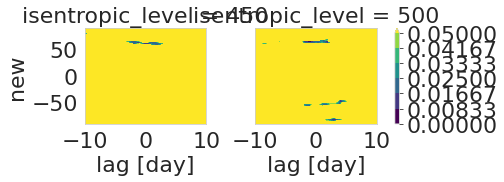

In [11]:
ds_all_pv.plot.contourf(x = 'lag', vmax = 0.05, vmin = 0, col = 'isentropic_level')
#plt.ylim(0,0.05)

# Preliminary visualization

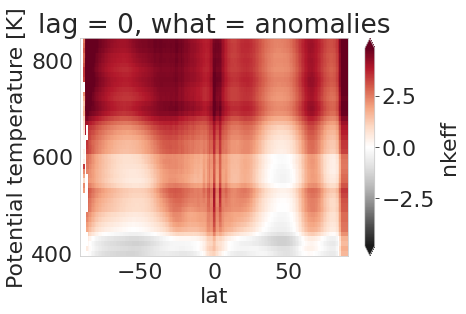

In [36]:
ds_all.sel(lag = 0, what = 'anomalies').plot(x = 'lat', 
                                            robust = True, 
                                            cmap = 'RdGy_r',
                                            extend = 'both')

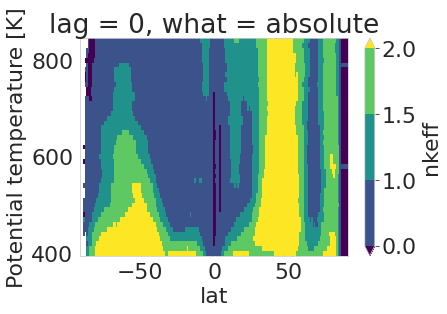

In [39]:
ds_all.sel(lag = 0, what = 'absolute').plot(x = 'lat', 
                                            robust = True, 
                                            cmap = 'viridis',
                                            levels = [0,1,1.5,2],
                                            extend = 'both')

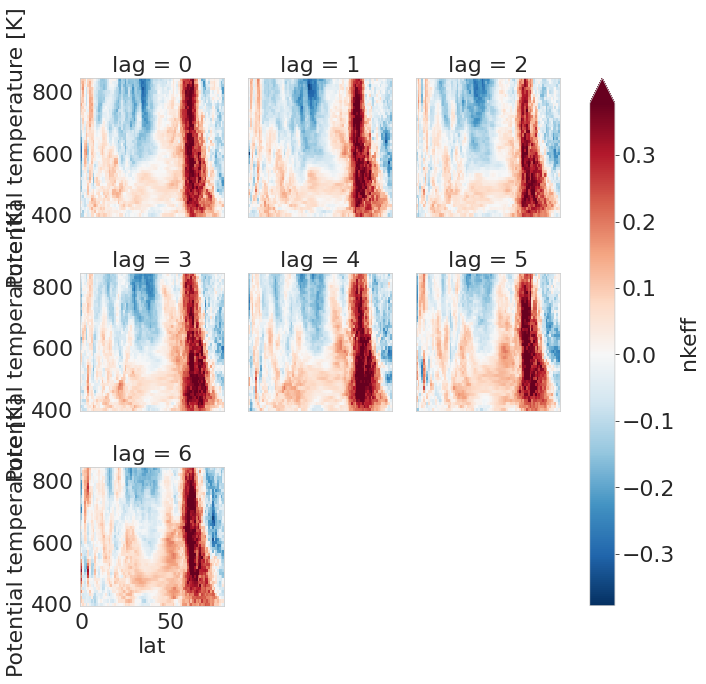

In [67]:
ds_all.sel(
    lag = slice(0,6),
    lat = slice(0,80),
    what = 'anomalies'
    ).plot(x = 'lat', 
           robust = True,
           col = 'lag',
           col_wrap = 3
           )

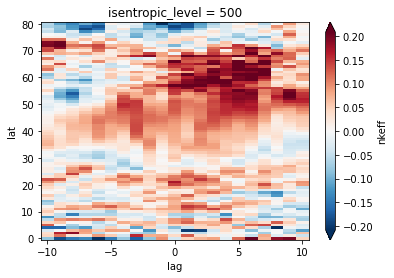

In [10]:
ds['nkeff'].sel(
    lat = slice(0,80),
    isentropic_level = sel_lev).plot(
    x = 'lag', robust = True)

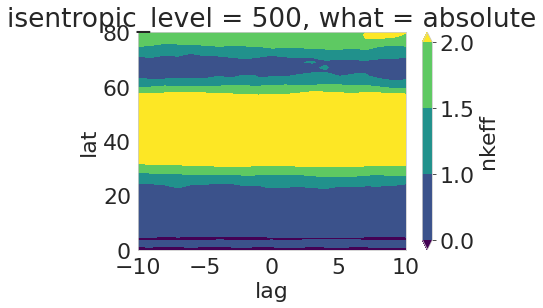

In [68]:
ds_all.sel(lat = slice(0,80), 
           what = 'absolute',
           isentropic_level = sel_lev).plot.contourf(x = 'lag', 
                                           levels = [0,1,1.5,2],
                                           cmap = 'viridis'                                                                                    
                                          )

# Final visualization

## from daily resampling

In [20]:
p.name_dicts

array([[{'isentropic_level': 450}, {'isentropic_level': 500}]],
      dtype=object)

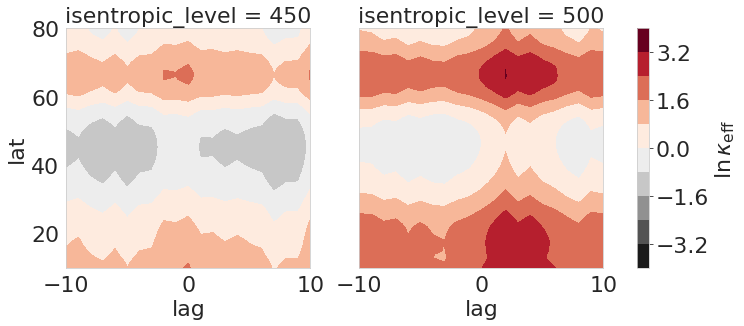

In [13]:
cbar_kwargs = dict(label=r'$\ln \kappa_{\mathrm{eff}}$')
lat_slice = slice(10,80)
sel_lev = [450,500]
cmap = 'PuOr_r'
cmap = 'RdGy_r'

p = ds_all.sel(
    lat = lat_slice,
    isentropic_level = sel_lev,
    what = 'anomalies').plot.contourf(
    x = 'lag', 
    col = 'isentropic_level',
    cmap = cmap,
    #robust = True, 
    levels = 11,
    size = 5, 
    cbar_kwargs=cbar_kwargs
)

In [32]:
sel_name['isentropic_level']

500

In [15]:
sel_lev

450

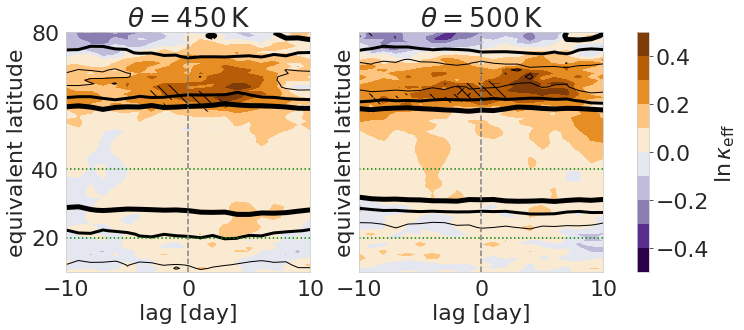

In [16]:
cbar_kwargs = dict(label=r'$\ln \kappa_{\mathrm{eff}}$')
lat_slice = slice(10,80)
sel_lev = [450,500]
cmap = 'PuOr_r'#'RdGy_r'

p = ds_all.sel(
    lat = lat_slice,
    isentropic_level = sel_lev,
    what = 'anomalies').plot.contourf(
    x = 'lag', 
    col = 'isentropic_level',
    cmap = cmap,
    #robust = True, 
    levels = 11,
    size = 5, 
    cbar_kwargs=cbar_kwargs
)

for sel_name, ax in zip(p.name_dicts.flat, p.axes.flat):
    ds_all.sel(lat = lat_slice, 
               what = 'absolute',
              ).sel(**sel_name).plot.contour(x = 'lag', 
                                               levels = [1,1.5,2],
                                               colors = ('k'),
                                               linewidths = [1,3,5],
                                               ax = ax
                                              )

    plot_kwargs = dict(levels = [0,0.05], hatches=['\\\\',None], ax = ax, \
                                colors='none', add_colorbar=False, x = 'lag')
    ds_all_pv.sel(lat=lat_slice).sel(**sel_name).plot.contourf(**plot_kwargs)
    plot_kwargs = dict(levels = [0,0.01], hatches=['//',None], ax = ax, \
                                colors='none', add_colorbar=False, x = 'lag')
    ds_all_pv.sel(lat=lat_slice).sel(**sel_name).plot.contourf(**plot_kwargs)

    """ds_all.sel(lat = slice(0,80), 
           what = 'absolute',
           isentropic_level = 500).plot.contour(x = 'lag', 
                                           levels = [0],
                                           colors = ('k'),
                                           linewidths = 5,
                                           ax = ax
                                          )"""

    ax.set_ylabel('equivalent latitude')
    sel_lev = sel_name['isentropic_level']
    ax.set_title(r'$\theta ='+f'{sel_lev}'+r'\,\mathrm{K}$')
    ax.axvline(x=0, c='gray', ls = 'dashed')
    ax.axhline(y=20, c='green', ls = 'dotted')
    ax.axhline(y=40, c='green', ls = 'dotted')



#plt.savefig(f'effective_diffusivity_HI-composite@{sel_lev}K_pv.pdf', bbox_inches='tight')

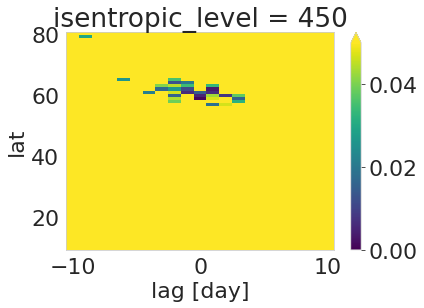

In [22]:
ds_all_pv.sel(lat=lat_slice, isentropic_level = 450).plot(x = 'lag', vmax = 0.05, vmin=0)

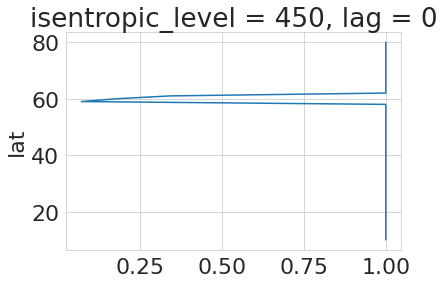

In [25]:
sel_lev = 450
temp = ds_all_pv.sel(
    lat=lat_slice, 
    isentropic_level = sel_lev,
    lag = [0]
).stack(
    z=('lag','lat')
)
fdr = fdrcorrection(temp)
fdr_pv = xr.DataArray(fdr[1], coords = temp.coords).unstack()
fdr_pv.squeeze().plot(y = 'lat')

In [27]:
sel_lev = 450
temp = ds_all_pv.sel(lat=slice(40,80), isentropic_level = sel_lev).stack(
    z=('lag','lat')
)
fdr = fdrcorrection(temp)
fdr_pv = xr.DataArray(fdr[1], coords = temp.coords).unstack()
fdr_pv

<xarray.DataArray (lag: 21, lat: 41)>
array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
...
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ]])
Coordinates:
    isentropic_level  int64 450
  * lag               (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 ... 3 4 5 6 7 8 9 10
  * lat               (lat) float64 40.0 41.0 42.0 43.0 ... 77.0 78.0 79.0 80.0

In [29]:
ds_all_pv_ren

<xarray.DataArray (lag: 21, isentropic_level: 2, lat: 181)>
array([[[1.06639961, 1.06639961, 1.06639961, ..., 0.20661826,
         0.20661826, 0.20661826],
        [1.06238078, 1.06238078, 1.06238078, ..., 0.36380534,
         0.36380534, 0.36380534]],

       [[0.88032975, 0.88032975, 0.88032975, ..., 0.12148666,
         0.12148666, 0.12148666],
        [0.83772916, 0.83772916, 0.83772916, ..., 0.40525441,
         0.40525441, 0.40525441]],

       [[0.58305559, 0.58305559, 0.58305559, ..., 2.03640295,
         2.03640295, 2.03640295],
        [0.77178662, 0.77178662, 0.77178662, ..., 2.05265337,
         2.05265337, 2.05265337]],

       ...,

       [[0.80591947, 0.80591947, 0.80591947, ..., 1.23676418,
         1.23676418, 1.23676418],
        [0.95670725, 0.95670725, 0.95670725, ..., 1.91115623,
         1.91115623, 1.91115623]],

       [[0.95313588, 0.95313588, 0.95313588, ..., 1.96939962,
         1.96939962, 1.96939962],
        [0.97549756, 0.97549756, 0.97549756, ..., 1.58594436,
         1.58594436, 1.58594436]],

       [[0.93371798, 0.93371798, 0.93371798, ..., 2.0402228 ,
         2.0402228 , 2.0402228 ],
        [0.99643795, 0.99643795, 0.99643795, ..., 1.90814239,
         1.90814239, 1.90814239]]])
Coordinates:
  * lat               (lat) float32 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * isentropic_level  (isentropic_level) int64 450 500
  * lag               (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 ... 3 4 5 6 7 8 9 10

In [32]:
sel_lev = 450
ds_all_pv_ren = ds_all_pv.rename({'new':'lat'})
temp = ds_all_pv_ren.sel(lat=lat_slice, isentropic_level = sel_lev).stack(
    z=('lag','lat')
)
fdr = fdrcorrection(temp)
fdr_pv = xr.DataArray(fdr[1], coords = temp.coords).unstack()
fdr_pv

<xarray.DataArray (lag: 21, lat: 71)>
array([[1.        , 1.        , 1.        , ..., 1.        , 0.98046023,
        0.98046023],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])
Coordinates:
    isentropic_level  int64 450
  * lag               (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 ... 3 4 5 6 7 8 9 10
  * lat               (lat) float64 10.0 11.0 12.0 13.0 ... 77.0 78.0 79.0 80.0

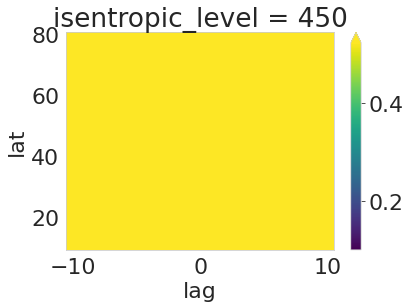

In [33]:
fdr_pv.plot(x = 'lag', vmax = 0.1)

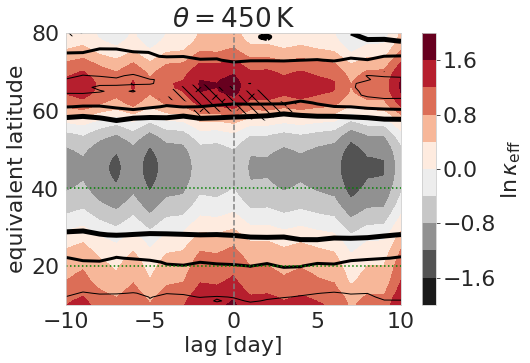

In [35]:
cbar_kwargs = dict(label=r'$\ln \kappa_{\mathrm{eff}}$')
lat_slice = slice(10,80)
cmap = 'PuOr_r'#
cmap = 'RdGy_r'

p = ds_all.sel(
    lat = lat_slice,
    isentropic_level = sel_lev,
    what = 'anomalies').plot.contourf(
    x = 'lag', 
    cmap = cmap,
    #robust = True, 
    levels = 11,
    size = 5, 
    cbar_kwargs=cbar_kwargs
)
ax = p.axes

ds_all.sel(lat = lat_slice, 
           what = 'absolute',
           isentropic_level = sel_lev).plot.contour(x = 'lag', 
                                           levels = [1,1.5,2],
                                           colors = ('k'),
                                           linewidths = [1,3,5],
                                           ax = ax
                                          )

plot_kwargs = dict(levels = [0,0.05], hatches=['\\\\',None], ax = ax, \
                                colors='none', add_colorbar=False, x = 'lag')
ds_all_pv_ren.sel(lat=lat_slice, isentropic_level = sel_lev).plot.contourf(**plot_kwargs)
plot_kwargs = dict(levels = [0,0.01], hatches=['//',None], ax = ax, \
                                colors='none', add_colorbar=False, x = 'lag')
ds_all_pv_ren.sel(lat=lat_slice, isentropic_level = sel_lev).plot.contourf(**plot_kwargs)

lot_kwargs = dict(levels = [0,0.05], colors='g', \
                           add_colorbar=False, \
                        ax=ax)
fdr_pv.sel(lat=lat_slice).plot.contour(**plot_kwargs)
    

"""ds_all.sel(lat = slice(0,80), 
           what = 'absolute',
           isentropic_level = 500).plot.contour(x = 'lag', 
                                           levels = [0],
                                           colors = ('k'),
                                           linewidths = 5,
                                           ax = ax
                                          )"""

ax.set_ylabel('equivalent latitude')
ax.set_xlabel('lag [day]')
ax.set_title(r'$\theta ='+f'{sel_lev}'+r'\,\mathrm{K}$')
ax.axvline(x=0, c='gray', ls = 'dashed')
ax.axhline(y=20, c='green', ls = 'dotted')
ax.axhline(y=40, c='green', ls = 'dotted')



plt.savefig(f'effective_diffusivity_HI-composite@{sel_lev}K_pv_FDR-xcontour.pdf', bbox_inches='tight')

## from 6-hourly resampling

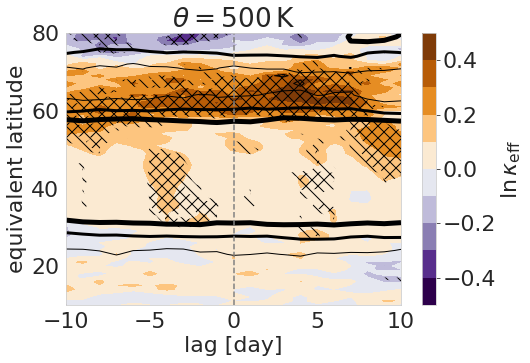

In [51]:
cbar_kwargs = dict(label=r'$\ln \kappa_{\mathrm{eff}}$')
lat_slice = slice(10,80)
cmap = 'PuOr_r'#'RdGy_r'
sel_lev = 500
p = ds_all.sel(
    lat = lat_slice,
    isentropic_level = sel_lev,
    what = 'anomalies').plot.contourf(
    x = 'lag', 
    cmap = cmap,
    #robust = True, 
    levels = 11,
    size = 5, 
    cbar_kwargs=cbar_kwargs
)
ax = p.axes

ds_all.sel(lat = lat_slice, 
           what = 'absolute',
           isentropic_level = sel_lev,).plot.contour(x = 'lag', 
                                           levels = [1,1.5,2],
                                           colors = ('k'),
                                           linewidths = [1,3,5],
                                           ax = ax
                                          )

plot_kwargs = dict(levels = [0,0.05], hatches=['\\\\',None], ax = ax, \
                                colors='none', add_colorbar=False, x = 'lag')
ds_all_pv.sel(lat=lat_slice, isentropic_level = sel_lev).plot.contourf(**plot_kwargs)
plot_kwargs = dict(levels = [0,0.01], hatches=['//',None], ax = ax, \
                                colors='none', add_colorbar=False, x = 'lag')
ds_all_pv.sel(lat=lat_slice, isentropic_level = sel_lev).plot.contourf(**plot_kwargs)

"""ds_all.sel(lat = slice(0,80), 
           what = 'absolute',
           isentropic_level = 500).plot.contour(x = 'lag', 
                                           levels = [0],
                                           colors = ('k'),
                                           linewidths = 5,
                                           ax = ax
                                          )"""

ax.set_ylabel('equivalent latitude')
ax.set_title(r'$\theta = 500\,\mathrm{K}$')
ax.axvline(x=0, c='gray', ls = 'dashed')

#plt.savefig('effective_diffusivity_HI-composite@500K.pdf', bbox_inches='tight')

### FDR

In [65]:
sel_lev = 450
temp = ds_all_pv.sel(lat=lat_slice, isentropic_level = sel_lev).stack(
    z=('lag','lat')
)
fdr = fdrcorrection(temp)
fdr_pv = xr.DataArray(fdr[1], coords = temp.coords).unstack()
fdr_pv

<xarray.DataArray (lag: 21, lat: 71)>
array([[1.        , 1.        , 1.        , ..., 0.51146628, 0.7424522 ,
        0.19870404],
       [1.        , 1.        , 1.        , ..., 0.08865884, 0.08036105,
        0.04998732],
       [1.        , 1.        , 1.        , ..., 0.0019739 , 0.0279922 ,
        0.08036105],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.85631695],
       [1.        , 1.        , 0.57030859, ..., 1.        , 1.        ,
        1.        ]])
Coordinates:
    isentropic_level  int64 450
  * lag               (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 ... 3 4 5 6 7 8 9 10
  * lat               (lat) float64 10.0 11.0 12.0 13.0 ... 77.0 78.0 79.0 80.0

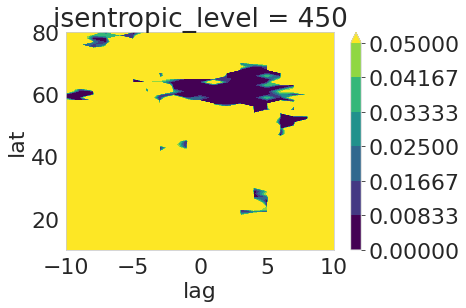

In [66]:
fdr_pv.sel(lat=lat_slice).plot.contourf(x = 'lag', vmin = 0, vmax = 0.05)

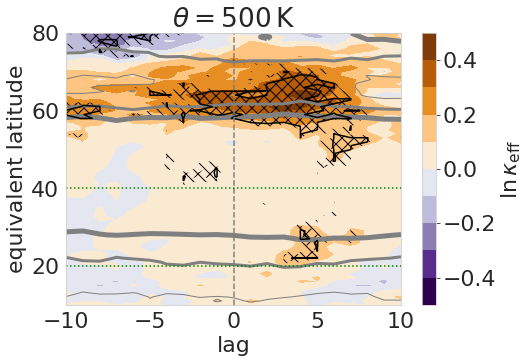

In [68]:
cbar_kwargs = dict(label=r'$\ln \kappa_{\mathrm{eff}}$')
lat_slice = slice(10,80)
cmap = 'PuOr_r'#'RdGy_r'

p = ds_all.sel(
    lat = lat_slice,
    isentropic_level = sel_lev,
    what = 'anomalies').plot.contourf(
    x = 'lag', 
    cmap = cmap,
    #robust = True, 
    levels = 11,
    size = 5, 
    cbar_kwargs=cbar_kwargs
)
ax = p.axes

ds_all.sel(lat = lat_slice, 
           what = 'absolute',
           isentropic_level = sel_lev,).plot.contour(x = 'lag', 
                                           levels = [1,1.5,2],
                                           colors = ('gray'),
                                           linewidths = [1,3,5],
                                           ax = ax
                                          )

plot_kwargs = dict(levels = [0,0.05], hatches=['\\\\',None], ax = ax, \
                                colors='none', add_colorbar=False, x = 'lag')
ds_all_pv.sel(lat=lat_slice, isentropic_level = sel_lev).plot.contourf(**plot_kwargs)
plot_kwargs = dict(levels = [0,0.01], hatches=['//',None], ax = ax, \
                                colors='none', add_colorbar=False, x = 'lag')
ds_all_pv.sel(lat=lat_slice, isentropic_level = sel_lev).plot.contourf(**plot_kwargs)
plot_kwargs = dict(levels = [0,0.01], colors='k', \
                           add_colorbar=False, \
                        ax=ax, x = 'lag')
fdr_pv.sel(lat=lat_slice).plot.contour(**plot_kwargs)
"""ds_all.sel(lat = slice(0,80), 
           what = 'absolute',
           isentropic_level = 500).plot.contour(x = 'lag', 
                                           levels = [0],
                                           colors = ('k'),
                                           linewidths = 5,
                                           ax = ax
                                          )"""

ax.set_ylabel('equivalent latitude')
ax.set_title(r'$\theta = 500\,\mathrm{K}$')
ax.axvline(x=0, c='gray', ls = 'dashed')
ax.axhline(y=20, c='green', ls = 'dotted')
ax.axhline(y=40, c='green', ls = 'dotted')
#plt.savefig('effective_diffusivity_HI-composite@500K.pdf', bbox_inches='tight')